In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow matplotlib numpy pandas scikit-learn


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# path of train_cancer folder to check how many images are present
images = glob('/content/drive/MyDrive/Skin Cancer Detection/Datasets/skin_cancer/train_cancer/*/*.jpg')
len(images)

250

In [ ]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[8]
df.head()


,filepath,label
0,/content/drive/MyDrive/Skin Cancer Detection/D...,malignant
1,/content/drive/MyDrive/Skin Cancer Detection/D...,malignant
2,/content/drive/MyDrive/Skin Cancer Detection/D...,malignant
3,/content/drive/MyDrive/Skin Cancer Detection/D...,malignant
4,/content/drive/MyDrive/Skin Cancer Detection/D...,malignant


In [ ]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()



,filepath,label,label_bin
0,/content/drive/MyDrive/Skin Cancer Detection/D...,malignant,1
1,/content/drive/MyDrive/Skin Cancer Detection/D...,malignant,1
2,/content/drive/MyDrive/Skin Cancer Detection/D...,malignant,1
3,/content/drive/MyDrive/Skin Cancer Detection/D...,malignant,1
4,/content/drive/MyDrive/Skin Cancer Detection/D...,malignant,1


In [ ]:
print(df['filepath'].head())
print(df['label'].head())

0    /content/drive/MyDrive/Skin Cancer Detection/D...
1    /content/drive/MyDrive/Skin Cancer Detection/D...
2    /content/drive/MyDrive/Skin Cancer Detection/D...
3    /content/drive/MyDrive/Skin Cancer Detection/D...
4    /content/drive/MyDrive/Skin Cancer Detection/D...
Name: filepath, dtype: object
0    malignant
1    malignant
2    malignant
3    malignant
4    malignant
Name: label, dtype: object


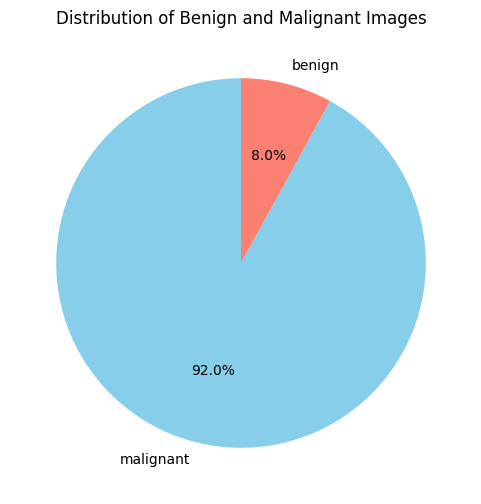

In [ ]:

plt.figure(figsize=(6, 6))
df['label'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'salmon'],

)
plt.ylabel('')
plt.title('Distribution of Benign and Malignant Images')
plt.show()


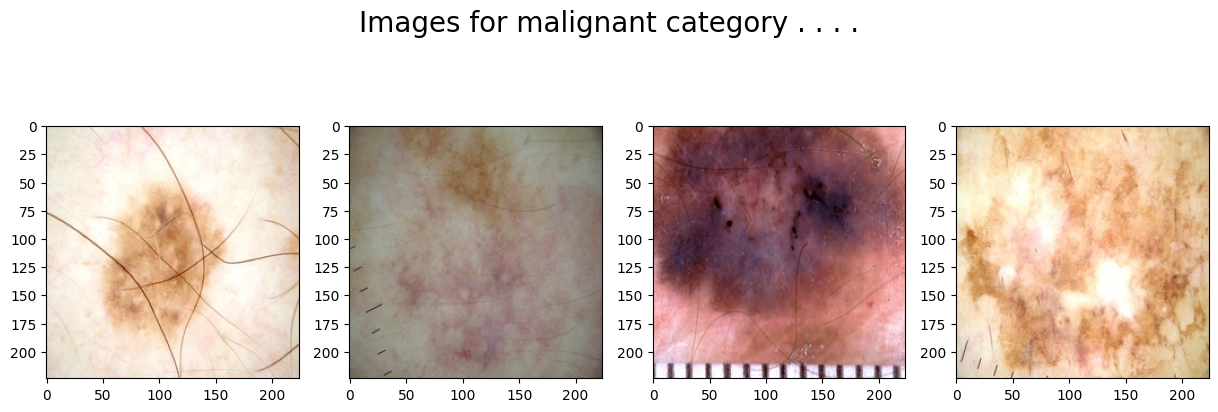

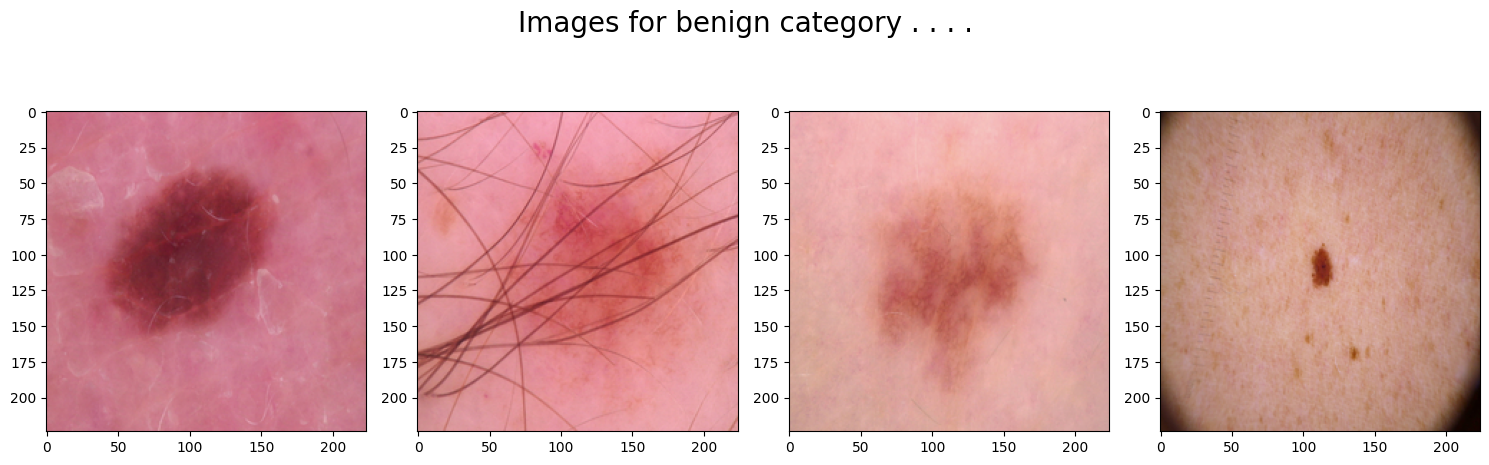

In [ ]:
for cat in df['label'].unique():
    temp = df[df['label'] == cat]

    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]

        image_path = data[0]

        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()


In [ ]:

features = df['filepath']
target = df['label_bin']

X_train, X_val,\
    y_train, y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape


((212,), (38,))

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
# Defining dataset paths
train_path = '/content/drive/MyDrive/Skin Cancer Detection/Datasets/skin_cancer/train_cancer'
test_path = '/content/drive/MyDrive/Skin Cancer Detection/Datasets/skin_cancer/test_cancer'

In [ ]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255)  # Normalizing image data
val_datagen = ImageDataGenerator(rescale=1./255)  # Same for validation data

In [ ]:

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'  # Binary classification
)

Found 250 images belonging to 2 classes.


In [ ]:

val_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),  # Resize images to the same size as training
    batch_size=64,
    class_mode='binary'
)

Found 20 images belonging to 2 classes.


In [ ]:

print("Class Indices:", train_generator.class_indices)

Class Indices: {'benign': 0, 'malignant': 1}


In [ ]:
# Computing class weights to handle class imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(zip(np.unique(train_generator.classes), class_weights))

In [ ]:
# Building the CNN Model
inputs = layers.Input(shape=(224, 224, 3))  # Input shape for the image (224x224x3)
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Dropout layer to reduce overfitting
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification (benign/malignant)

model = Model(inputs, outputs)

In [ ]:

# Compile the model
model.compile(
    loss='binary_crossentropy',  # Loss function for binary classification
    optimizer=Adam(),  # Adam optimizer
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,277,697 (84.98 MB)

 Trainable params: 22,277,697 (84.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model with early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weight_dict,  # Apply class weights during training
    callbacks=[early_stop]  # Early stopping to avoid overfitting
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.4323 - loss: 1.2748 - val_accuracy: 0.5000 - val_loss: 0.9540
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.8938 - loss: 0.6972 - val_accuracy: 0.5000 - val_loss: 0.6574
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.9010 - loss: 0.6029 - val_accuracy: 0.7500 - val_loss: 0.5146
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.7544 - loss: 0.5644 - val_accuracy: 0.8000 - val_loss: 0.4815
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.7793 - loss: 0.4612 - val_accuracy: 0.8000 - val_loss: 0.4618
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7708 - loss: 0.3830 - val_accuracy: 0.8500 - val_loss: 0.4265
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.7498 - loss: 0.3706 - val_accuracy: 0.7000 - val_loss: 0.6158
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.9095 - loss: 0.3908 - val_accuracy: 0.7500 - val_loss: 0

In [ ]:
# Saving the model for later use
model.save('/content/drive/MyDrive/Skin Cancer Detection/My_Model.h5')

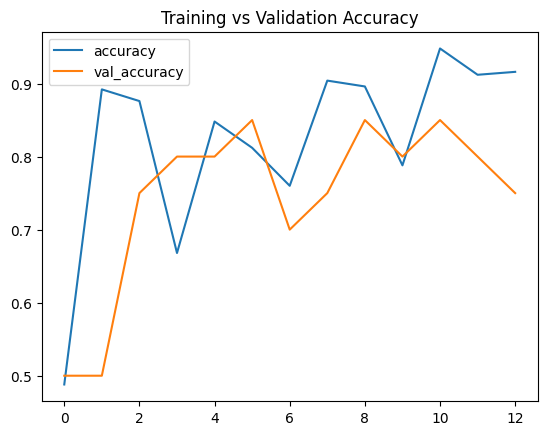

In [ ]:
# Plotting accuracy and loss graphs
hist_df = pd.DataFrame(history.history)
hist_df[['accuracy', 'val_accuracy']].plot()
plt.title('Training vs Validation Accuracy')
plt.show()


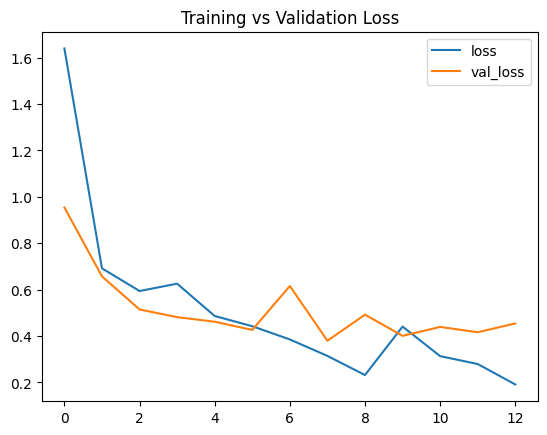

In [ ]:
hist_df[['loss', 'val_loss']].plot()
plt.title('Training vs Validation Loss')
plt.show()


In [ ]:
# Loading the model
model = tf.keras.models.load_model('/content/drive/MyDrive/Skin Cancer Detection/My_Model.h5')

In [ ]:
# Testing the model on a single image
test_image_path = '/content/drive/MyDrive/Skin Cancer Detection/Datasets/skin_cancer/test_cancer/malignant/118.jpg'  # Example image

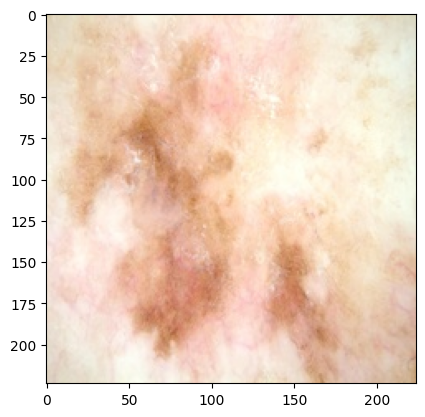

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
Prediction: Malignant


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
test_image = load_img(test_image_path, target_size=(224, 224))
plt.imshow(test_image)
plt.show()

test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image)

if prediction[0] > 0.5:
   print("Prediction: Malignant")
else:
   print("Prediction: Benign")

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import tensorflow as tf
from PIL import Image
import numpy as np

model = tf.keras.models.load_model('/content/drive/MyDrive/Skin Cancer Detection/My_Model.h5')

def predict_skin_cancer(image):
    image = image.resize((224, 224))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    prediction = model.predict(image_array)

    if prediction[0] > 0.5:
        return "Malignant", "red"
    else:
        return "Benign", "green"

html_code = """
<div style="text-align:center; font-family: 'Arial', sans-serif; padding: 20px; background: linear-gradient(135deg, #6e7c7c, #f7f7f7); border-radius: 10px; box-shadow: 0 4px 15px rgba(0, 0, 0, 0.1);">
    <h1 style="color: #4CAF50; font-size: 36px; margin-bottom: 20px;">Skin Cancer Detection</h1>
    <p style="font-size: 18px; color: #555;">Upload an image to check if it is benign or malignant. Our model will give you the result instantly!</p>
</div>
"""
css_code = """
    .gradio-container {
        background: #f0f0f0;
        padding: 30px;
        border-radius: 12px;
        box-shadow: 0 4px 20px rgba(0, 0, 0, 0.1);
    }
    .gradio-button {
        background: linear-gradient(45deg, #4CAF50, #45a049);
        color: white;
        padding: 12px 25px;
        border-radius: 8px;
        font-size: 18px;
        transition: transform 0.2s ease;
        border: none;
    }
    .gradio-button:hover {
        transform: scale(1.1);
          transform: scale(1.1);
        background: linear-gradient(45deg, #45a049, #4CAF50);
    }
    .gradio-input-image {
        border: 2px solid #ddd;
        border-radius: 10px;
        padding: 10px;
    }
    .gradio-output-text {
        font-size: 24px;
        font-weight: bold;
        color: #333;
        margin-top: 20px;
        text-transform: capitalize;
    }
    .gradio-footer {
        color: #666;
        font-size: 14px;
        margin-top: 20px;
    }
"""

interface = gr.Interface(
    fn=predict_skin_cancer,
    inputs=gr.Image(type="pil", label="Upload Image of Skin Lesion"),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Textbox(label="Additional Information")
    ],
    title="Skin Cancer Detection",
    description=html_code,
    live=True,
    theme="compact",
    examples=None,
    css=css_code,
)
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5c9b4b678bf69b40e1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# interface.launch(share=False)